# Zero-Shot Learning - Part 2 - Quick, Draw!

This notebook will detail the preparation of the Numpy bitmaps from the Quick, Draw! data set. The original data set can be found here.

https://github.com/googlecreativelab/quickdraw-dataset

## Quick, Draw!

This data set is the result of players contributing to the Quick, Draw game. There are 345 categories and millions of drawings to pull from. We will only be selecting 10 classes to match those from CIFAR-10 (with one modification).

Let's take a look at the data.

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np

qd_dir = os.path.expanduser('~/data/QuickDraw')

dolphins = np.load(os.path.join(qd_dir, 'full%2Fnumpy_bitmap%2Fdolphin.npy'))

print(dolphins.shape)

(121613, 784)


The data are stored in a format very similar to MNIST, so we will have to reshape it in the same way.

(-0.5, 27.5, 27.5, -0.5)

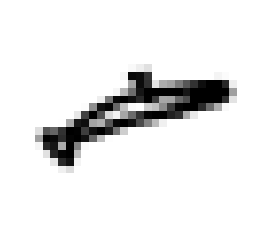

In [17]:
a_dolphin = dolphins[40]
a_dolphin_pic = a_dolphin.reshape(28, 28)

plt.imshow(a_dolphin_pic, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")

## Training Set Creation

We will use the same (alphabetical) category as CIFAR-10, but replace deer with dolphin. Thankfully, that means we can keep the other labels the same.

In [19]:
airplanes = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_airplane.npy'))

automobiles = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_car.npy'))

birds = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_bird.npy'))

cats = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_cat.npy'))

# already loaded dolphins

dogs = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_dog.npy'))

frogs = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_frog.npy'))

horses = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_horse.npy'))

ships = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_cruise ship.npy'))

trucks = np.load(os.path.join(qd_dir, 'full_numpy_bitmap_truck.npy'))

X = np.concatenate((airplanes, automobiles, birds, cats, dolphins, dogs, frogs, horses, ships, trucks), axis=0)

In [20]:
X.shape

(1457030, 784)

In [ ]:
num_samples = X.shape[0]
y = np.zeros(num_samples)

y[

Re-instantiate our model and load the weights learned in the previous notebook.

In [3]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_test.shape[1:], name='conv1'))
model.add(BatchNormalization(axis=3, name='bn_conv1'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), name='conv2'))
model.add(BatchNormalization(axis=3, name='bn_conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', name='conv3'))
model.add(BatchNormalization(axis=3, name='bn_conv3'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), name='conv4'))
model.add(BatchNormalization(axis=3, name='bn_conv4'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, name='fc1'))
model.add(BatchNormalization(axis=1, name='bn_fc1'))
model.add(Activation('relu'))
model.add(Dense(num_classes, name='output'))
model.add(BatchNormalization(axis=1, name='bn_outptut'))
model.add(Activation('softmax'))

model.load_weights(weights_path)

Define a new model that will simply return the output from the second-to-last activation layer from the CNN above.

In [5]:
import numpy as np

feat_extractor = Model(inputs=model.input,
                       outputs=model.get_layer('fc1').output)

features = feat_extractor.predict(x_test, batch_size=batch_size)

np.save(os.path.join(out_dir, 'fc1_features.npy'), features)

## PCA - FC 1

Now use PCA to pare down the dimensionality of the feature vector from 512 to 256.

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(features)
pca_features = pca.transform(features)

np.save(os.path.join(out_dir, 'fc1_features_pca_2dim.npy'), pca_features)

Now normalize.

In [28]:
tx, ty = pca_features[:,0], pca_features[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

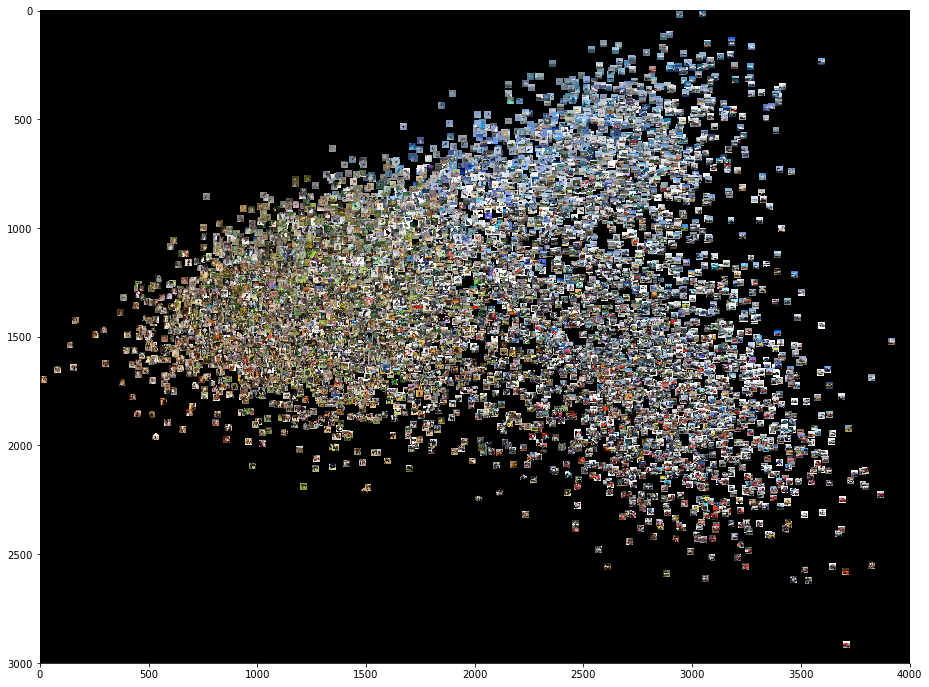

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(x_test):
    tile = Image.fromarray(np.uint8(x * 255))
    #tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * tx[idx]), int((height-max_dim) * ty[idx])))

%matplotlib inline
plt.figure(figsize = (16,12))
plt.imshow(full_image)

In [30]:
full_image.save(os.path.join(out_dir, "fc1_pca.jpg"))

## PCA (50 dimensions) Followed by t-SNE - FC 1

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(features)
pca_features = pca.transform(features)

np.save(os.path.join(out_dir, 'fc1_features_pca_50dim.npy'), pca_features)

Now use t-SNE to compress down further.

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(pca_features)

In [37]:
np.save(os.path.join(out_dir, 'fc1_features_pca_50dim_tsne.npy'), tsne)

Now normalize.

In [38]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

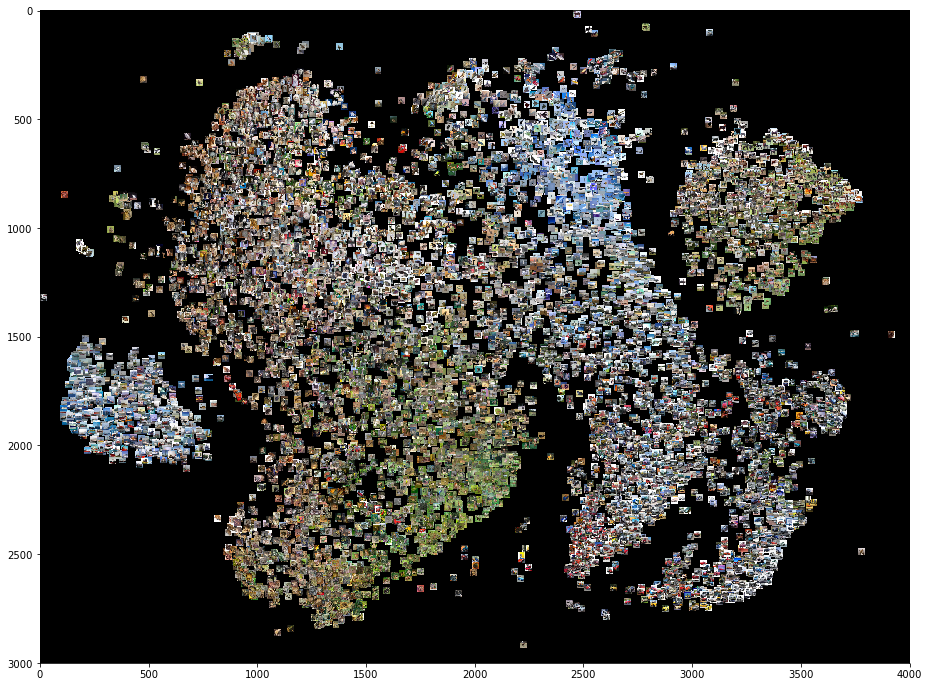

In [39]:
import matplotlib.pyplot as plt
from PIL import Image

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(x_test):
    tile = Image.fromarray(np.uint8(x * 255))
    #tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * tx[idx]), int((height-max_dim) * ty[idx])))

%matplotlib inline
plt.figure(figsize = (16,12))
plt.imshow(full_image)

In [40]:
full_image.save(os.path.join(out_dir, "fc1_features_pca_50dim_tsne.jpg"))

## t-SNE with Default Settings - FC 1

Now use t-SNE with default settings and no PCA compression ahead of time.

In [42]:
from sklearn.manifold import TSNE

features = np.load(os.path.join(out_dir, 'fc1_features.npy'))
tsne = TSNE().fit_transform(features)

In [43]:
np.save(os.path.join(out_dir, 'fc1_features_tsne_default.npy'), tsne)

Now normalize.

In [44]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

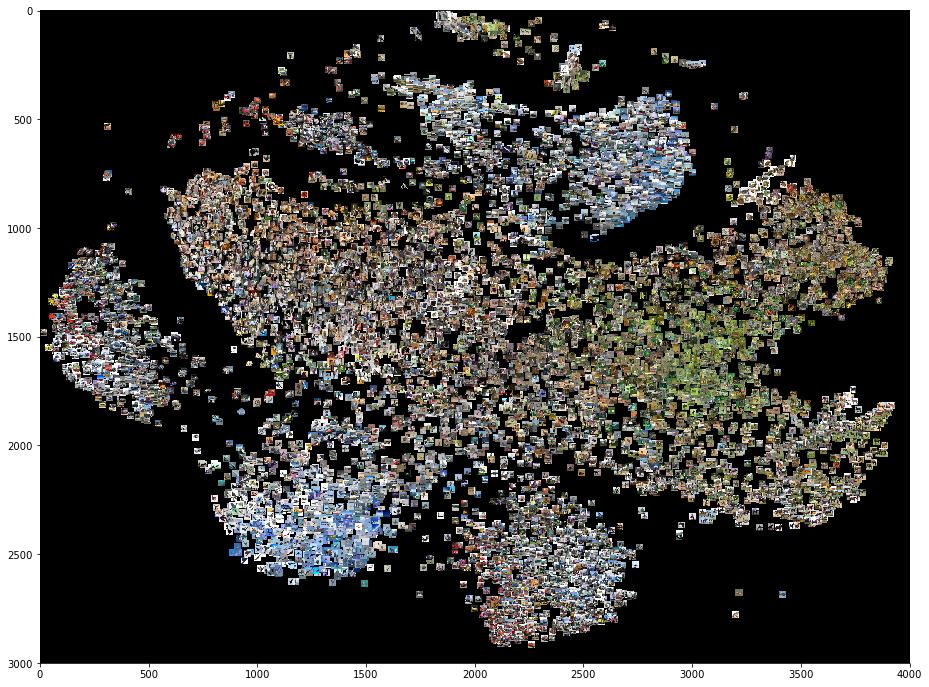

In [45]:
import matplotlib.pyplot as plt
from PIL import Image

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(x_test):
    tile = Image.fromarray(np.uint8(x * 255))
    #tile = Image.open(img)
    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs),
                        int(tile.height / rs)),
                       Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * tx[idx]),
                            int((height-max_dim) * ty[idx])))

%matplotlib inline
plt.figure(figsize = (16,12))
plt.imshow(full_image)

In [46]:
full_image.save(os.path.join(out_dir, "fc1_features_tsne_default.jpg"))

Now re-do the t-SNE plot, but display categories rather than images.

In [49]:
# have to re-load cifar to get y_test back in its original form
_, (x_test, y_test) = cifar10.load_data()

y_test = np.asarray(y_test)

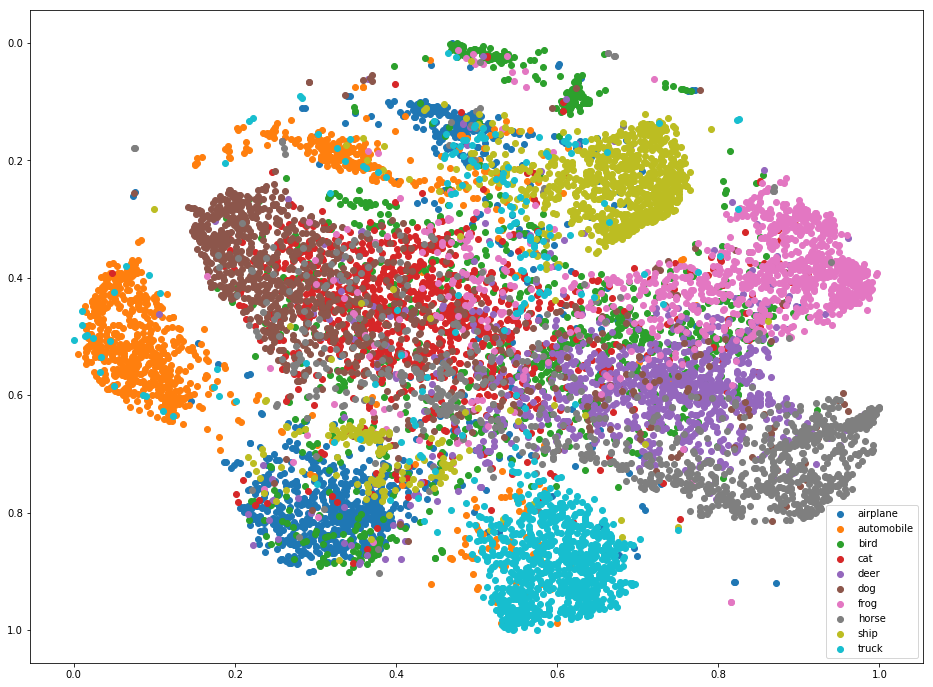

In [93]:
plt.figure(figsize = (16,12))

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(len(classes)):
    y_i = y_test == i
    plt.scatter(tx[y_i[:, 0]], ty[y_i[:, 0]], label=classes[i])
plt.legend(loc=4)
plt.gca().invert_yaxis()
plt.savefig(os.path.join(out_dir, "fc1_features_tsne_default_pts.jpg"), bbox_inches='tight')
plt.show()